# ACSE-3 (Numerical Methods) <a class="tocSkip">

## Lecture 11: Finite element methods (FEM) 1 <a class="tocSkip">
    
### Homework exercises <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Homework" data-toc-modified-id="Homework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework</a></span><ul class="toc-item"><li><span><a href="#Homework---Solving-on-a-non-uniform-mesh" data-toc-modified-id="Homework---Solving-on-a-non-uniform-mesh-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Homework - Solving on a non-uniform mesh</a></span></li><li><span><a href="#Homework---A-BVP-with-an-inhomogeneous-RHS-and-inhomogeneous-Dirichlet-BCs" data-toc-modified-id="Homework---A-BVP-with-an-inhomogeneous-RHS-and-inhomogeneous-Dirichlet-BCs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Homework - A BVP with an inhomogeneous RHS and inhomogeneous Dirichlet BCs</a></span></li><li><span><a href="#Homework---Another-BVP-with-a-slightly-more-complex-RHS" data-toc-modified-id="Homework---Another-BVP-with-a-slightly-more-complex-RHS-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Homework - Another BVP with a slightly more complex RHS</a></span></li><li><span><a href="#Homework---A-more-complex-BVP-(method-of-manufactured-solutions)" data-toc-modified-id="Homework---A-more-complex-BVP-(method-of-manufactured-solutions)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Homework - A more complex BVP (method of manufactured solutions)</a></span></li><li><span><a href="#Homework---A-problem-with-non-constant-coefficients-[$\star\star$]" data-toc-modified-id="Homework---A-problem-with-non-constant-coefficients-[$\star\star$]-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Homework - A problem with non-constant coefficients [$\star\star$]</a></span></li><li><span><a href="#Homework---Approximation-using-a-discontinuous-function-[$\star$]" data-toc-modified-id="Homework---Approximation-using-a-discontinuous-function-[$\star$]-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Homework - Approximation using a discontinuous function [$\star$]</a></span></li><li><span><a href="#Homework---Errors-in-function-approximation-[$\star$]" data-toc-modified-id="Homework---Errors-in-function-approximation-[$\star$]-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Homework - Errors in function approximation [$\star$]</a></span></li></ul></li></ul></div>

In [3]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

In [4]:
# some useful function from the lecture

def hat_function(i, x_nodes):
    """ Top hat basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (x_nodes[i+1] - x)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (x - x_nodes[i-1])/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (x-x_nodes[i-1])/dx[i-1], (x_nodes[i+1]-x)/dx[i] ] ,0.0)
    return hat

def hat_function_deriv(i, x_nodes):
    """ Top hat basis function derivative at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ -1/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ 1/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ 1/dx[i-1], -1/dx[i] ] ,0.0)
    return hat

def mass_matrix(x):
    dx = np.diff(x)
    M = np.zeros((len(x), len(x)))
    M[1:-1,1:-1] = np.diag(dx[:-1]/3  +  dx[1:]/3 , k=0) 
    M += np.diag(dx/6   , k=-1) + np.diag(dx/6   , k=1)
    M[0,0] = dx[0]/3
    M[-1,-1] = dx[-1]/3
    return M


# don't need the composite version of Simpson's rule here - want the version
# that is able to integrate over a single interval and evaluates the function
# at the two end points as well as the mid point
def simpsons_rule(a, b, function, number_intervals=10):
    """ Function to evaluate Simpson's rule. 
    
    Note that this implementation takes the function as an argument, 
    and evaluates this at the midpoint of subintervals in addition to the 
    end point. Hence additional information is generated and used through 
    additional function evaluations. 
    
    This is different to the function/implementation available with SciPy  
    where discrete data only is passed to the function. 
    
    Bear this in mind when comparing results - there will be a factor of two
    in the definition of "n" we need to be careful about!
    
    Also note that this version of the function performs redundant function 
    evaluations - see the **composite** implementation below.
    """

    interval_size = (b - a)/number_intervals

    assert interval_size > 0
    assert type(number_intervals) == int

    I_S = 0.0

    # Loop to valuate Simpson's formula over each interval 
    for i in range(number_intervals):
        # Find a, c, and b
        this_bin_start = a + interval_size * (i)
        this_bin_mid = this_bin_start + interval_size/2
        this_bin_end = this_bin_start + interval_size
        # Calculate the rule and add to running total.
        I_S += (interval_size/6) * (function(this_bin_start) +
                                  4 * function(this_bin_mid) + function(this_bin_end))

    # Return our running total result
    return I_S

def simpsons_composite_rule(a, b, function, number_intervals=10):
    """Function to evaluate the composite Simpson's rule only using
    function evaluations at (number_intervals + 1) points.
    
    This implementation requires that the number of subintervals (number_intervals) be even
    """
    assert number_intervals % 2 == 0, "number_intervals is not even"

    interval_size = (b - a) / number_intervals
    # start with the two end member values
    I_cS2 = function(a) + function(b)

    # add in those terms with a coefficient of 4
    for i in range(1, number_intervals, 2):
        I_cS2 += 4 * function(a + i * interval_size)

    # and those terms with a coefficient of 2
    for i in range(2, number_intervals-1, 2):
        I_cS2 += 2 * function(a + i * interval_size)

    return I_cS2 * (interval_size / 3.0)

# Homework


## Homework - Solving on a non-uniform mesh

We saw that for the initial BVP problem we considere in the class (homogeneous Dirichlet conditions with $f\equiv 1$) that the solution we obtained with exact (to round-off) at the nodes.

Confirm that this exactness is no longer true on a non-uniform mesh - try perturbing our internal nodes (i.e. keep the boundaries where they should be!)  a small random amount.

In [22]:
a = np.random.normal(0,0.005,8)
a.mean()

0.0012437889471390443

In [23]:
# let's discretise and solve our problem using hte FEM

def f(x):
    return 1.0

def u_exact(x):
    return -0.5*x*(x-1)

N_elements_CG = 9
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
a = np.random.normal(0,0.005,8)
x_nodes[1:-1] += a
dx = np.diff(x_nodes)

# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG -2 , N_nodes_CG -2 ))

# we only need the internal entries of the A defined above in this case
K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)

# print out K to show that we've lost the first and last rows/columns compared to the previous K we printed
print(K)

# form RHS vector by integrating function f multiplied by basis function
# loop over internal nodes
RHS = np.zeros(N_nodes_CG - 2)
for node in range(1, N_nodes_CG - 1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # simpsons with number intervals = 2 can integrate this exactly
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )

u = sl.solve(K,RHS)

[[18.186004   -9.36371331  0.          0.          0.          0.
   0.          0.        ]
 [-9.36371331 18.38797912 -9.02426581  0.          0.          0.
   0.          0.        ]
 [ 0.         -9.02426581 17.25168201 -8.22741621  0.          0.
   0.          0.        ]
 [ 0.          0.         -8.22741621 17.90542187 -9.67800566  0.
   0.          0.        ]
 [ 0.          0.          0.         -9.67800566 18.70977401 -9.03176835
   0.          0.        ]
 [ 0.          0.          0.          0.         -9.03176835 17.78615775
  -8.75438941  0.        ]
 [ 0.          0.          0.          0.          0.         -8.75438941
  17.75498819 -9.00059878]
 [ 0.          0.          0.          0.          0.          0.
  -9.00059878 18.24968053]]


error (RMS at nodes only) =  0.000985902339254941


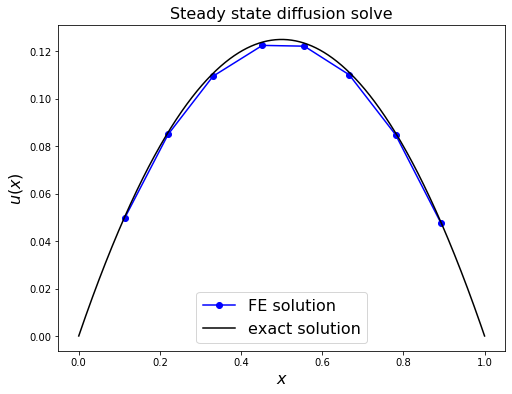

In [24]:
# plot the exact and our numerical solution and print out the RMS error
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:-1], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, -0.5*x_fine*(x_fine-1), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS at nodes only) = ', 
      sl.norm(u - (-0.5*x_nodes[1:-1]*(x_nodes[1:-1]-1)) )
      /np.sqrt(len(u)) )

## Homework - A BVP with an inhomogeneous RHS and inhomogeneous Dirichlet BCs

Consider the problem 

$$-u'' = f, $$

with

$$ f \equiv -1,$$

and BCs

$$u(0)=0, \;\;\;\; u(1)=1.$$

First derive the exact solution (integrate up twice and use the BCs to fix the constants of integration), and then use this solution to verify an appropriately implemented FEM solution.

u = 0.5*x**2 + 0.5*x

error (RMS at nodes only) =  1.0686797729075024e-16


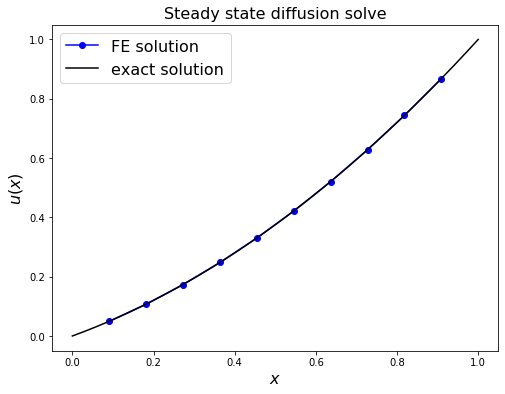

In [26]:
uL = 0.
uR = 1.

def f(x):
    return -1.

def u_exact(x):
    return 0.5*(x**2+x)


N_elements_CG = 11
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)
# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
RHS = np.zeros(N_nodes_CG - 2)

K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)

# form RHS vector by integrating function f multiplied by basis function
# loop over internal nodes
for node in range(1, N_nodes_CG - 1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # simpsons with number intervals = 2 can integrate this exactly
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )

    
# Add in the extra entries due to the inhomogeneous BCs

# At the left the integral is only non-zero when phi_i and phi_0 both have
# support - this only occurs over the first element when i=1 (remembering that i=0
# isn't in our trial space. The integrand is then
# uL multiplied by the derivative of \phi_1 in the first cell (1/dx[0])
# multiplied by the derivative of \phi_0 in the first cell (-1/dx[0]).
# This is a constant, and hence to do the integral we just need to 
# multiply by the size of the cell (dx[0]):
RHS[0] = RHS[0] - (uL * 1/dx[0] * (-1/dx[0]))*dx[0]
# and similarly for the RHS
RHS[-1] = RHS[-1] - (uR * (-1/dx[-1]) * (1/dx[-1]))*dx[-1]

u = sl.solve(K,RHS)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:-1], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, u_exact(x_fine), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS at nodes only) = ', 
      sl.norm(u - u_exact(x_nodes[1:-1]) )
      /np.sqrt(len(u)) )

## Homework - Another BVP with a slightly more complex RHS

Consider the problem

$$u'' = x \;\;\;\;\;\;\text{or}\;\;\; -u'' = -x.$$

Integrate up twice to obtain the exact solution with two arbitrary constants of integration.

Consider the domain and use the the boundary conditions

$$u(0) = 0, \;\;\;\;\;\; u(1)=1,$$

to fix the values of the two constants in your exact solution.

Solve the problem using the finite element method and compare with your exact solution.

error (RMS at nodes only) =  2.9060631111760165e-16


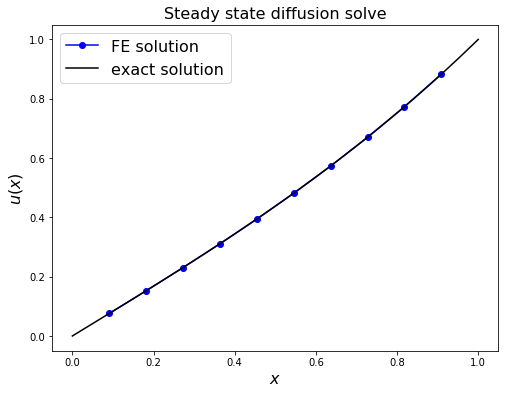

In [28]:
uL = 0.
uR = 1.

def f(x):
    return -x

def u_exact(x):
    return (x**3)/6. + (5./6.)*x


N_elements_CG = 11
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)
# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
RHS = np.zeros(N_nodes_CG - 2)

K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)

# form RHS vector by integrating function f multiplied by basis function
# loop over internal nodes
for node in range(1, N_nodes_CG - 1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # simpsons with number intervals = 2 can integrate this exactly
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )

    
# Add in the extra entries due to the inhomogeneous BCs

# At the left the integral is only non-zero when phi_i and phi_0 both have
# support - this only occurs over the first element when i=1 (remembering that i=0
# isn't in our trial space. The integrand is then
# uL multiplied by the derivative of \phi_1 in the first cell (1/dx[0])
# multiplied by the derivative of \phi_0 in the first cell (-1/dx[0]).
# This is a constant, and hence to do the integral we just need to 
# multiply by the size of the cell (dx[0]):
RHS[0] = RHS[0] - (uL * 1/dx[0] * (-1/dx[0]))*dx[0]
# and similarly for the RHS
RHS[-1] = RHS[-1] - (uR * (-1/dx[-1]) * (1/dx[-1]))*dx[-1]

u = sl.solve(K,RHS)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:-1], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, u_exact(x_fine), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS at nodes only) = ', 
      sl.norm(u - u_exact(x_nodes[1:-1]) )
      /np.sqrt(len(u)) )

## Homework - A more complex BVP (method of manufactured solutions)

Consider the solution function

$$ u(x) = -6 x + x^3 + \frac{5}{\sin(1)}\sin(x). $$

Verify that $u(0)=0$ and $u(1)=0$ for this function.

Compute

$$ f := u'' + u.$$

Solve the problem 

$$ u'' + u = f,$$

with the $f$ you've calculated on the interval $[0,1]$, with homogeneous Dirichlet BCs.


If you computed $f$ correctly, and implemented your solver correctly, you should be able to demonstrate convergence to the exact solution we started with.

[Hint: the solver for this problem involve use of the discretisation matrix $A$ we've used muiltupled times for simple BVPs, along with the mass matrix $M$].


error (RMS) =  1.6532517164756132e-05


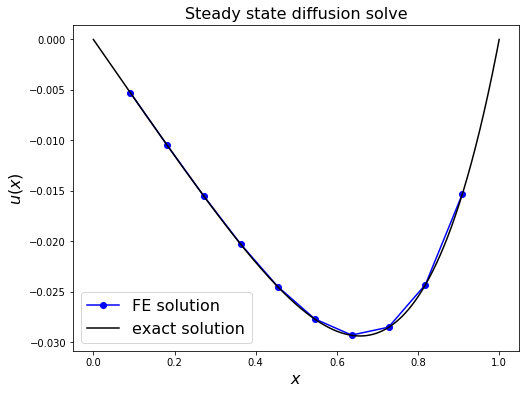

In [31]:
uL = 0.
uR = 0.

def f(x):
    return x**3

def u_exact(x):
    return -6*x + x**3 + 5*np.sin(x)/np.sin(1)


N_elements_CG = 11
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)
# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
Mass = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
RHS = np.zeros(N_nodes_CG - 2)

# construct mass matrix
Mass_full = mass_matrix(x_nodes)
# we don't want the full mass matrix for this problem with Dirichlet conditions
# so just grab the internal bit
Mass = Mass_full[1:-1,1:-1]

# construct discretisation matrix for second deriv
K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)

# form RHS vector by integrating function f multiplied by basis function
# loop over internal nodes
for node in range(1, N_nodes_CG - 1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # we need a higher number of intervals to do this accurately with non-uniform mesh
    # but trivial if we split the integrals over each individual element ( as we would
    # with assembly of course)
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )

    
# Add in the extra entries due to the inhomogeneous Dirichlet BCs

# At the left the integral is only non-zero when phi_i and phi_0 both have
# support - this only occurs over the first element. The integrand is then
# uL multiplied by the derivative of \phi_1 in the first cell (1/dx[0])
# multiplied by the derivative of \phi_0 in the first cell (-1/dx[0]).
# This is a constant, and hence to do the integral we just need to 
# multiply by the size of the cell (dx[0]):
RHS[0] = RHS[0] - (uL * 1/dx[0] * (-1/dx[0]))*dx[0]
# and similarly for the RHS
RHS[-1] = RHS[-1] - (uR * (-1/dx[-1]) * (1/dx[-1]))*dx[-1]

Disc = -K + Mass         ##################!!!!!!!!!!!!!!!!?????????????????????
u = sl.solve(Disc, RHS)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:-1], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, u_exact(x_fine), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS) = ', 
      sl.norm(u - u_exact(x_nodes[1:-1]) )
      /np.sqrt(len(u)) )

## Homework - A problem with non-constant coefficients [$\star\star$]

The next step in complexity is thinking about how we would go about solving problems with non-constant coefficients.

The added complexity here is that we need to incorporate the variation of coefficients when we compute the entries of the LHS discretisation matrices

For example consider the general diffusion like problem

$$ -(au')' = f, $$

where $a\equiv a(x)$ is a potentially non-constant diffusion coefficient.

Consider diffusion of heat in a bar where $f(x)$ represents a hear source and $a(x)$ represents the heat conductivity.

Suppose we are in the interval $I=[0,1]$ with the completely general [*Robin boundary conditions*](https://en.wikipedia.org/wiki/Robin_boundary_condition)

$$ au'(0) = C_L\,(u(0) - g_L), \;\;\;\;\; au'(1) = C_R\,(u(1) - g_R).$$

The parameters $C_L$ and $C_R$ can be used to control the relative contributions of the Dirichlet and Neumann conditions, with $g_L$ and $g_R$ the applied value of the BC.  For example, in the limit of $C$ being small we recover a homogeneous Neumann condition (and we are free to choose the $C$'s to be zero of course), and in the large limit we approximate a Dirichlet BC.  Note that this means if we implement a general solver with these Robin BC, through the choice of $C$ very large or very small (or actually zero), we approximate the implementation of these BCs.

Try developing a solver for this case and apply it to a problem where the diffusivity is given by

$$ a(x) = 0.1(1 - 0.5x),$$

the source by

$$ f(x) = 10(x - 0.6)^4,$$

and with the BCs

$$u(0) = -1, \;\;\;\;\; u'(1) = 0.$$

In [ ]:
def u_exact(x):
    return 
    
def f(x):
    return 10*(x-0.6)**4

## Homework - Approximation using a discontinuous function [$\star$]

We saw in the lecture how to approximate a given function using a p/w linear **continuous** function via $L^2$ projection (which involved deriving the system with the mass matrix and solving for the weights in our expansion in terms of the basis functions).

We can generalise this to a case where we approximate our given function with a p/w linear **discontinuous** function.  This essentially means that instead of having one unknown at every node, we actually have two, each of which "belongs" to the element either side of the mesh vertex.

We thus have more degrees of freedom to solve for (so we expect an improved solution), and need to think about the appropriate set of test functions to use to obtain the appropriately sizes square discrete system to solve.  To do this we simply split our basis functions so each of them is only half of the hat function.

Suggest you take a look at my solution and try to follow what is going on.

## Homework - Errors in function approximation [$\star$]

Now compute the $L^2$ norms of the errors in the three different approximations from the previous question.